In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2023-04-30 12:34:00.399617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.11.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('../data/ch18_train.csv')
val_df = pd.read_csv('../data/ch18_val.csv')
test_df = pd.read_csv('../data/ch18_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(24464, 7) (6990, 7) (3495, 7)


## `DataWindow` class 

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [10]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

### Repeat last value 

In [11]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [12]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

2023-04-30 12:35:48.766117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


217/217 [==============================] - 1s 2ms/step - loss: 0.1788 - mean_absolute_error: 0.3018


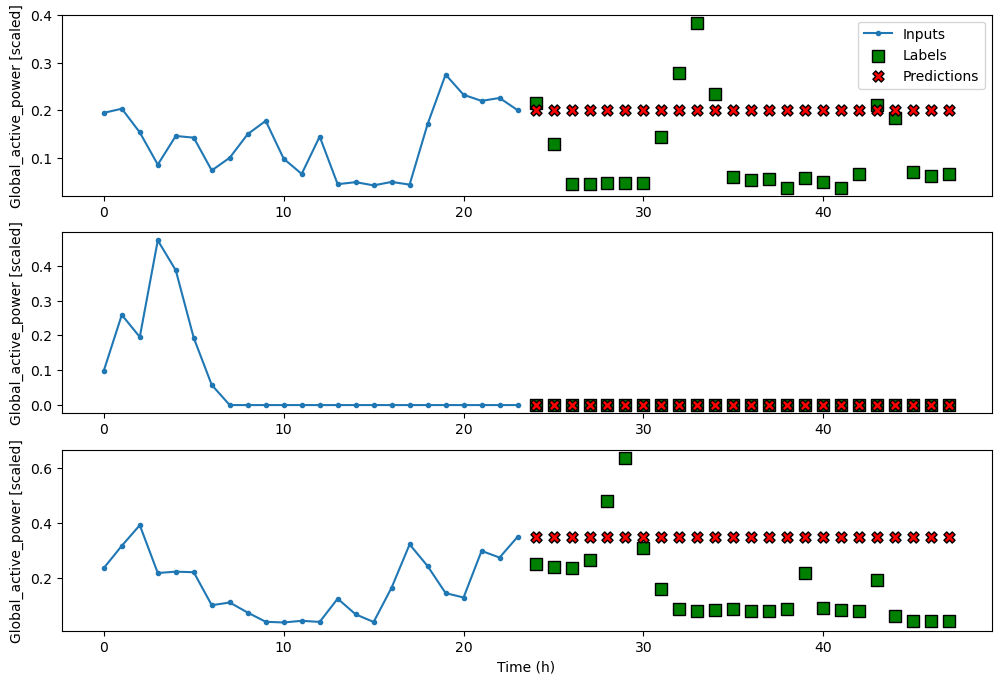

In [13]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [14]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [15]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 1s 2ms/step - loss: 0.1786 - mean_absolute_error: 0.2962


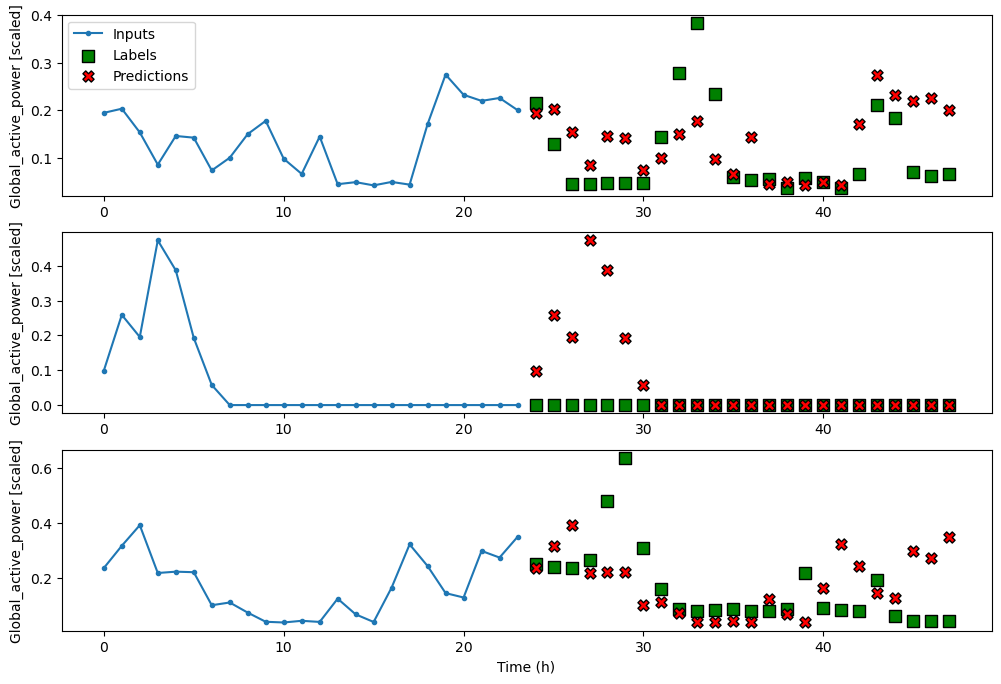

In [16]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [ ]:
label_index = column_indices['Global_active_power']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

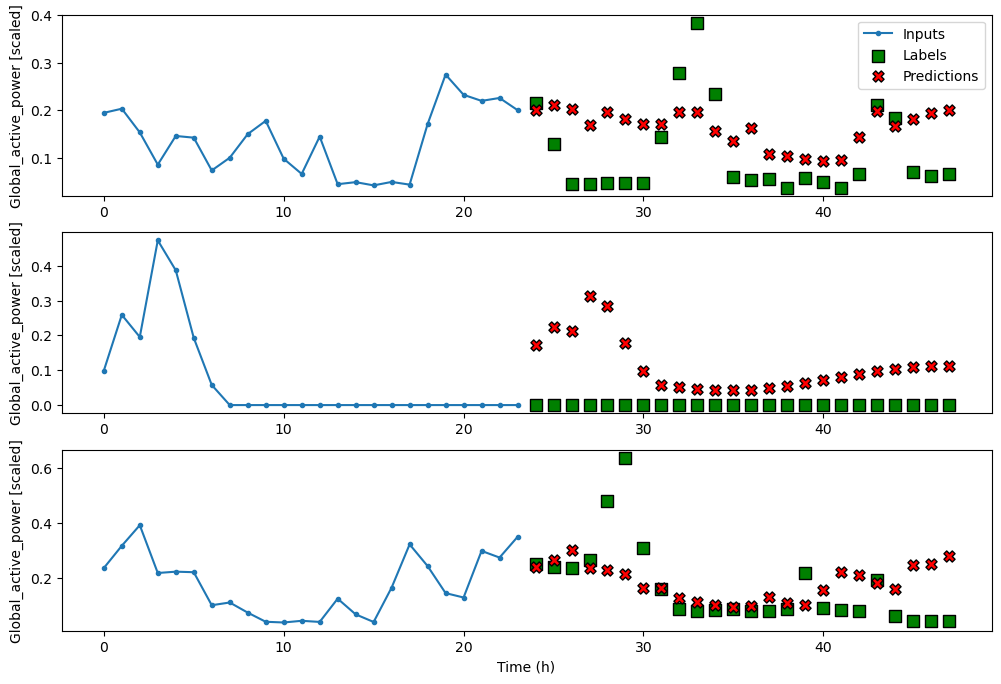

In [18]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [19]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 6s 7ms/step - loss: 0.0155 - mean_absolute_error: 0.0927 - val_loss: 0.0130 - val_mean_absolute_error: 0.0829
Epoch 2/50
764/764 [==============================] - 5s 7ms/step - loss: 0.0147 - mean_absolute_error: 0.0896 - val_loss: 0.0129 - val_mean_absolute_error: 0.0832
Epoch 3/50
764/764 [==============================] - 4s 6ms/step - loss: 0.0147 - mean_absolute_error: 0.0895 - val_loss: 0.0129 - val_mean_absolute_error: 0.0841
Epoch 4/50
764/764 [==============================] - 5s 6ms/step - loss: 0.0146 - mean_absolute_error: 0.0895 - val_loss: 0.0129 - val_mean_absolute_error: 0.0838
Epoch 5/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0146 - mean_absolute_error: 0.0894 - val_loss: 0.0130 - val_mean_absolute_error: 0.0829
Epoch 6/50
217/217 [==============================] - 1s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0855


## LSTM model 

In [20]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 16s 18ms/step - loss: 0.0166 - mean_absolute_error: 0.0974 - val_loss: 0.0129 - val_mean_absolute_error: 0.0855
Epoch 2/50
764/764 [==============================] - 15s 19ms/step - loss: 0.0146 - mean_absolute_error: 0.0898 - val_loss: 0.0128 - val_mean_absolute_error: 0.0846
Epoch 3/50
764/764 [==============================] - 13s 18ms/step - loss: 0.0145 - mean_absolute_error: 0.0890 - val_loss: 0.0128 - val_mean_absolute_error: 0.0833
Epoch 4/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0128 - val_mean_absolute_error: 0.0833
Epoch 5/50
764/764 [==============================] - 18s 24ms/step - loss: 0.0144 - mean_absolute_error: 0.0885 - val_loss: 0.0127 - val_mean_absolute_error: 0.0839
Epoch 6/50
764/764 [==============================] - 14s 19ms/step - loss: 0.0143 - mean_absolute_error: 0.0884 - val_loss: 0.0127 - val_mean_absolute_error: 0.0840
Epoc

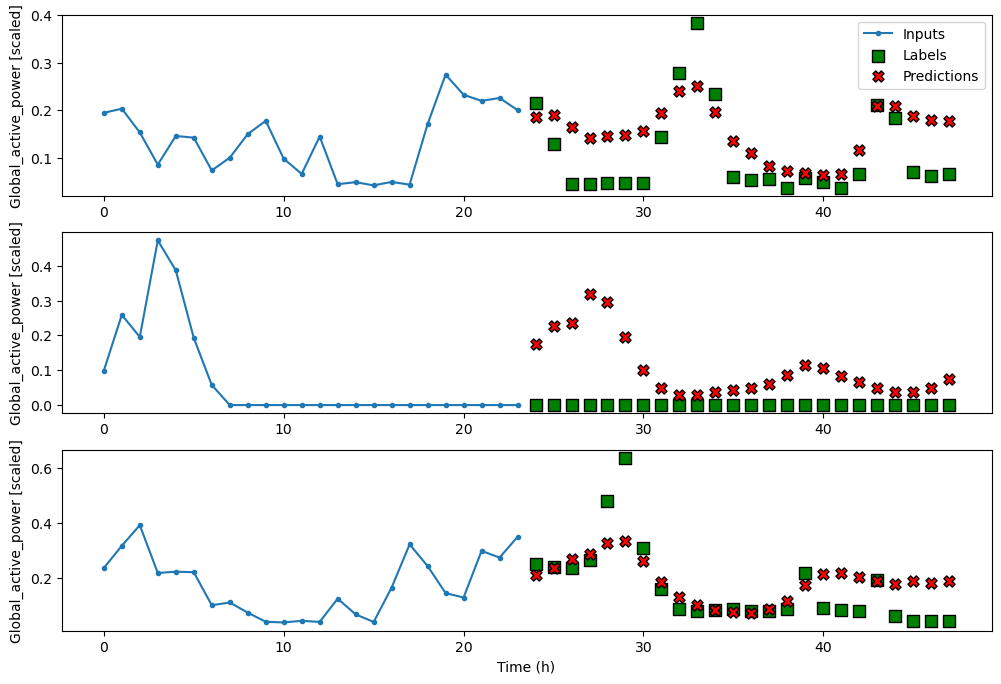

In [21]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [22]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [23]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 5s 6ms/step - loss: 0.0157 - mean_absolute_error: 0.0933 - val_loss: 0.0127 - val_mean_absolute_error: 0.0830
Epoch 2/50
763/763 [==============================] - 5s 7ms/step - loss: 0.0145 - mean_absolute_error: 0.0889 - val_loss: 0.0128 - val_mean_absolute_error: 0.0837
Epoch 3/50
763/763 [==============================] - 7s 8ms/step - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0128 - val_mean_absolute_error: 0.0833
Epoch 4/50
217/217 [==============================] - 1s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0827


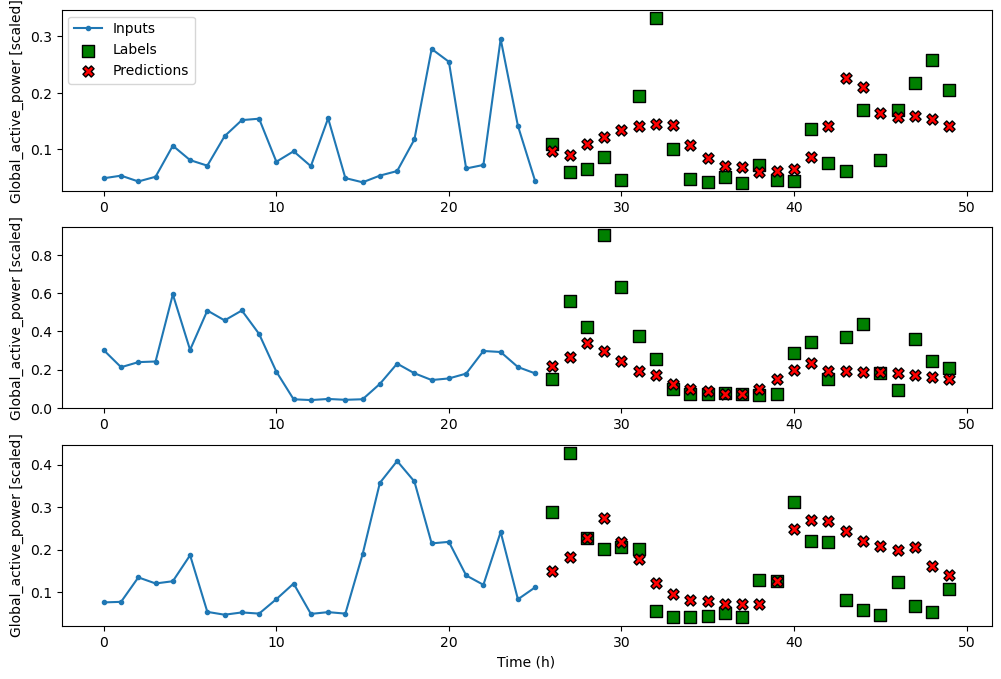

In [24]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [25]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 15s 17ms/step - loss: 0.0162 - mean_absolute_error: 0.0958 - val_loss: 0.0130 - val_mean_absolute_error: 0.0852
Epoch 2/50
763/763 [==============================] - 19s 25ms/step - loss: 0.0145 - mean_absolute_error: 0.0893 - val_loss: 0.0129 - val_mean_absolute_error: 0.0838
Epoch 3/50
763/763 [==============================] - 16s 21ms/step - loss: 0.0143 - mean_absolute_error: 0.0884 - val_loss: 0.0128 - val_mean_absolute_error: 0.0838
Epoch 4/50
763/763 [==============================] - 17s 22ms/step - loss: 0.0143 - mean_absolute_error: 0.0881 - val_loss: 0.0129 - val_mean_absolute_error: 0.0842
Epoch 5/50
763/763 [==============================] - 18s 24ms/step - loss: 0.0142 - mean_absolute_error: 0.0878 - val_loss: 0.0129 - val_mean_absolute_error: 0.0854
Epoch 6/50
217/217 [==============================] - 2s 8ms/step - loss: 0.0130 - mean_absolute_error: 0.0840


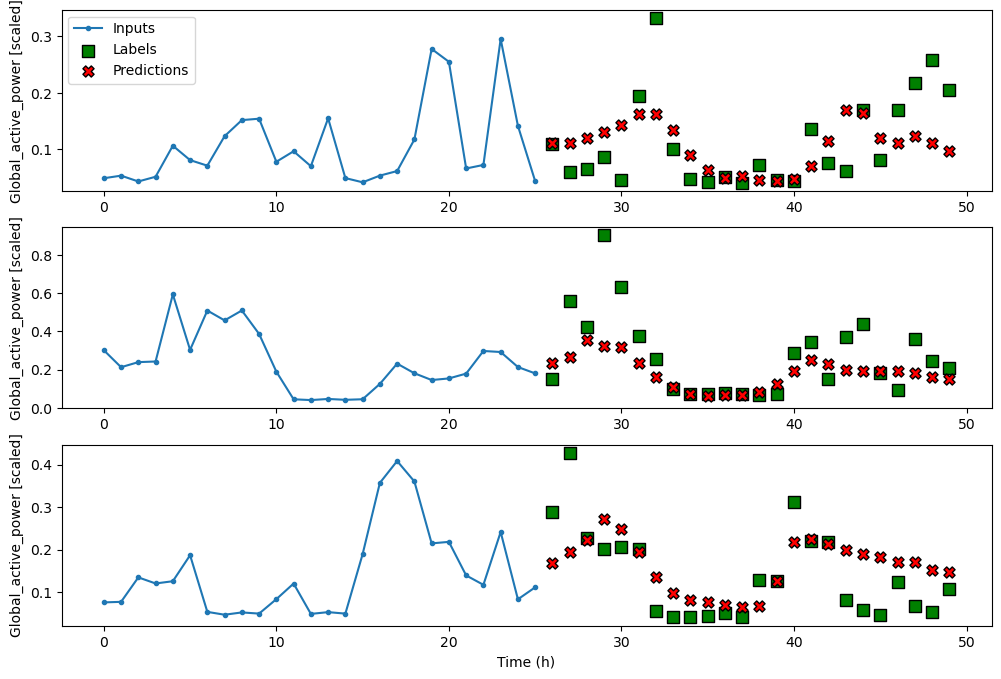

In [26]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [27]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [28]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 21s 22ms/step - loss: 0.0180 - mean_absolute_error: 0.1049 - val_loss: 0.0136 - val_mean_absolute_error: 0.0868
Epoch 2/50
764/764 [==============================] - 16s 21ms/step - loss: 0.0142 - mean_absolute_error: 0.0880 - val_loss: 0.0126 - val_mean_absolute_error: 0.0843
Epoch 3/50
764/764 [==============================] - 17s 22ms/step - loss: 0.0139 - mean_absolute_error: 0.0870 - val_loss: 0.0126 - val_mean_absolute_error: 0.0828
Epoch 4/50
764/764 [==============================] - 17s 22ms/step - loss: 0.0139 - mean_absolute_error: 0.0866 - val_loss: 0.0121 - val_mean_absolute_error: 0.0821
Epoch 5/50
764/764 [==============================] - 17s 22ms/step - loss: 0.0138 - mean_absolute_error: 0.0862 - val_loss: 0.0121 - val_mean_absolute_error: 0.0819
Epoch 6/50
764/764 [==============================] - 18s 23ms/step - loss: 0.0137 - mean_absolute_error: 0.0858 - val_loss: 0.0123 - val_mean_absolute_error: 0.0834
Epoc

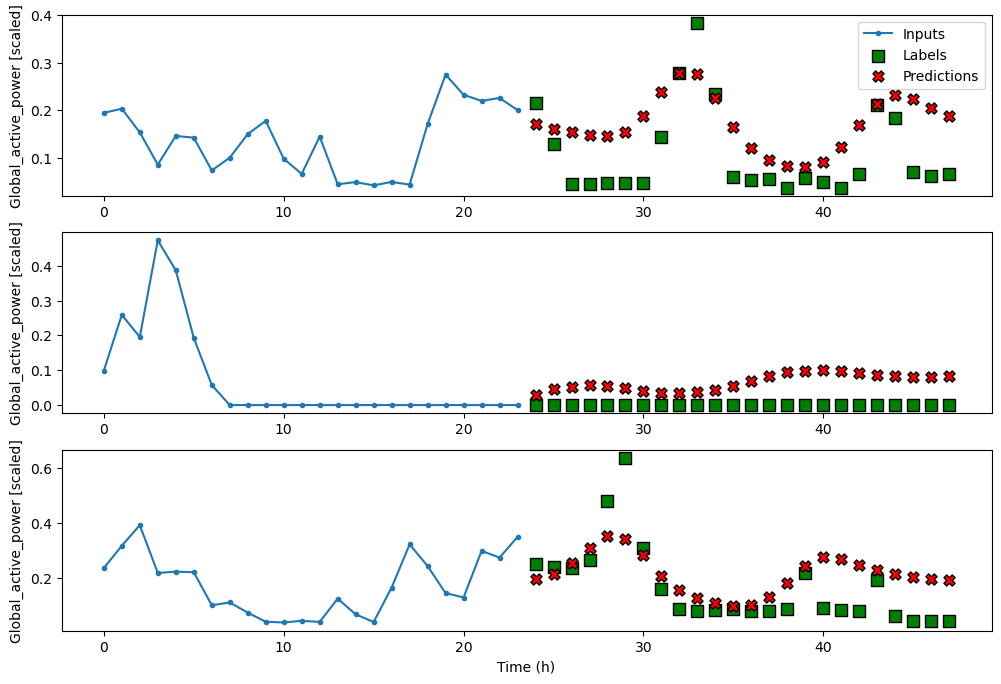

In [29]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

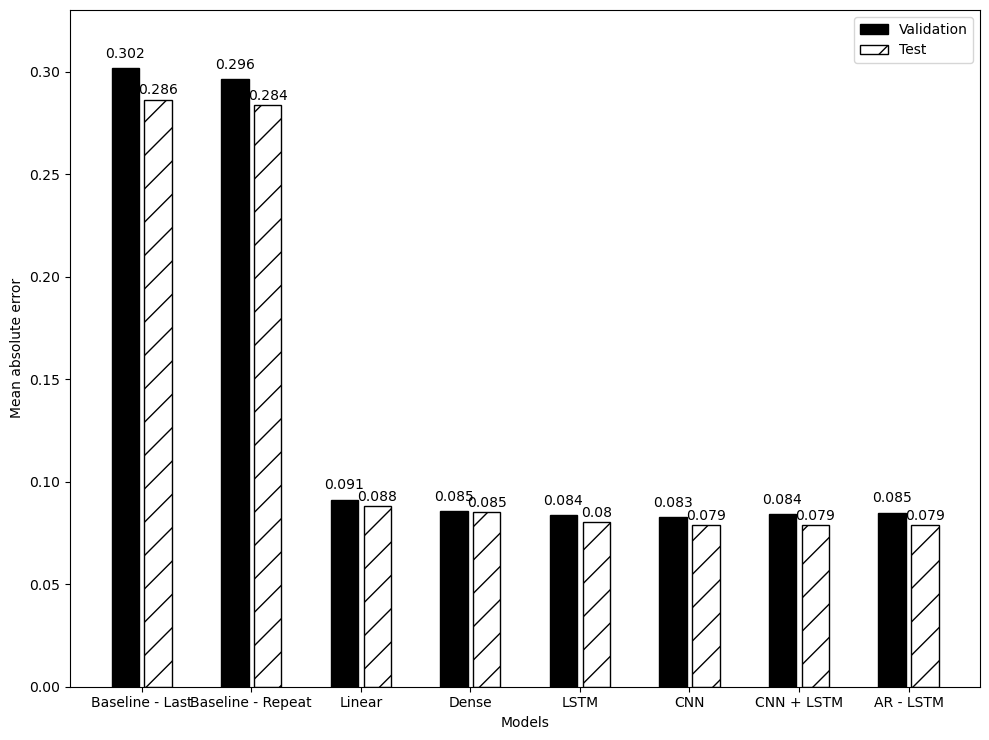

In [30]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)